# Tumor Detection with Machine Learning
### Rado Haluška and Mitchell Borchers

In [48]:
import pandas as pd
import numpy as np

data = pd.read_csv('data.csv').drop('Unnamed: 0', axis=1)
labels = pd.read_csv('labels.csv').drop('Unnamed: 0', axis=1)


The data had gene information for tumors from patients with Breast Cancer, Colon Adenocarcinoma, Kidney Renal Cell Carcinoma, Lung Adenocarcinoma, and Prostate Adenocarcinoma. We had 801 data samples (patients) and 20,531 features (genes). The genes didn't have the full names in the dataset that we had but instead were just numbered. It seems that the gene names were available at some other location online. 

In [47]:
print(np.unique(labels['Class']))
print(labels.shape)
print(data.shape)
data.head()

['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']
(801, 1)
(801, 20532)


,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Class
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,1
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,1
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,1
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,0


Next we wanted to explore PCA. For 95% explained variance we needed 530 components, for 99% explained variance we needed 725 components and for .99999% we needed 800 components. These results are interesting when looking back after we have done some feature reduction. Here we use Standard Scaler but other scaling methods could also be used.

20


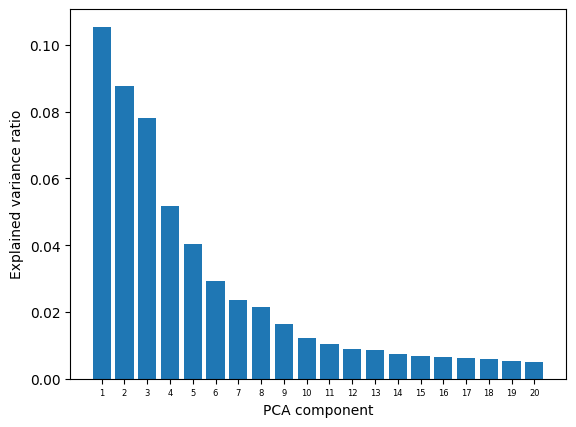

In [69]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Scale the data
data_scaled = StandardScaler().fit_transform(data)

# PCA analysis
pca = PCA(n_components=20)
pca.fit(data_scaled)
tumor_data = pca.transform(data_scaled)
n_pcs= pca.components_.shape[0]

plt.bar(range(1,n_pcs+1), pca.explained_variance_ratio_)
plt.xlabel('PCA component')
plt.ylabel('Explained variance ratio')
plt.xticks(range(1,n_pcs+1), size=6)
plt.show()




Similarly to what we have done in class we will transpose our data. For visualization (and further computations) we map the tables using the first two principal components (n_components=2) obtained from Principal Component Analysis as well as use KDE to visualize the density. In class we worked with data where we had some binary classification. Here we have data for 5 different tumors, so for this scenario we will use one vs rest.

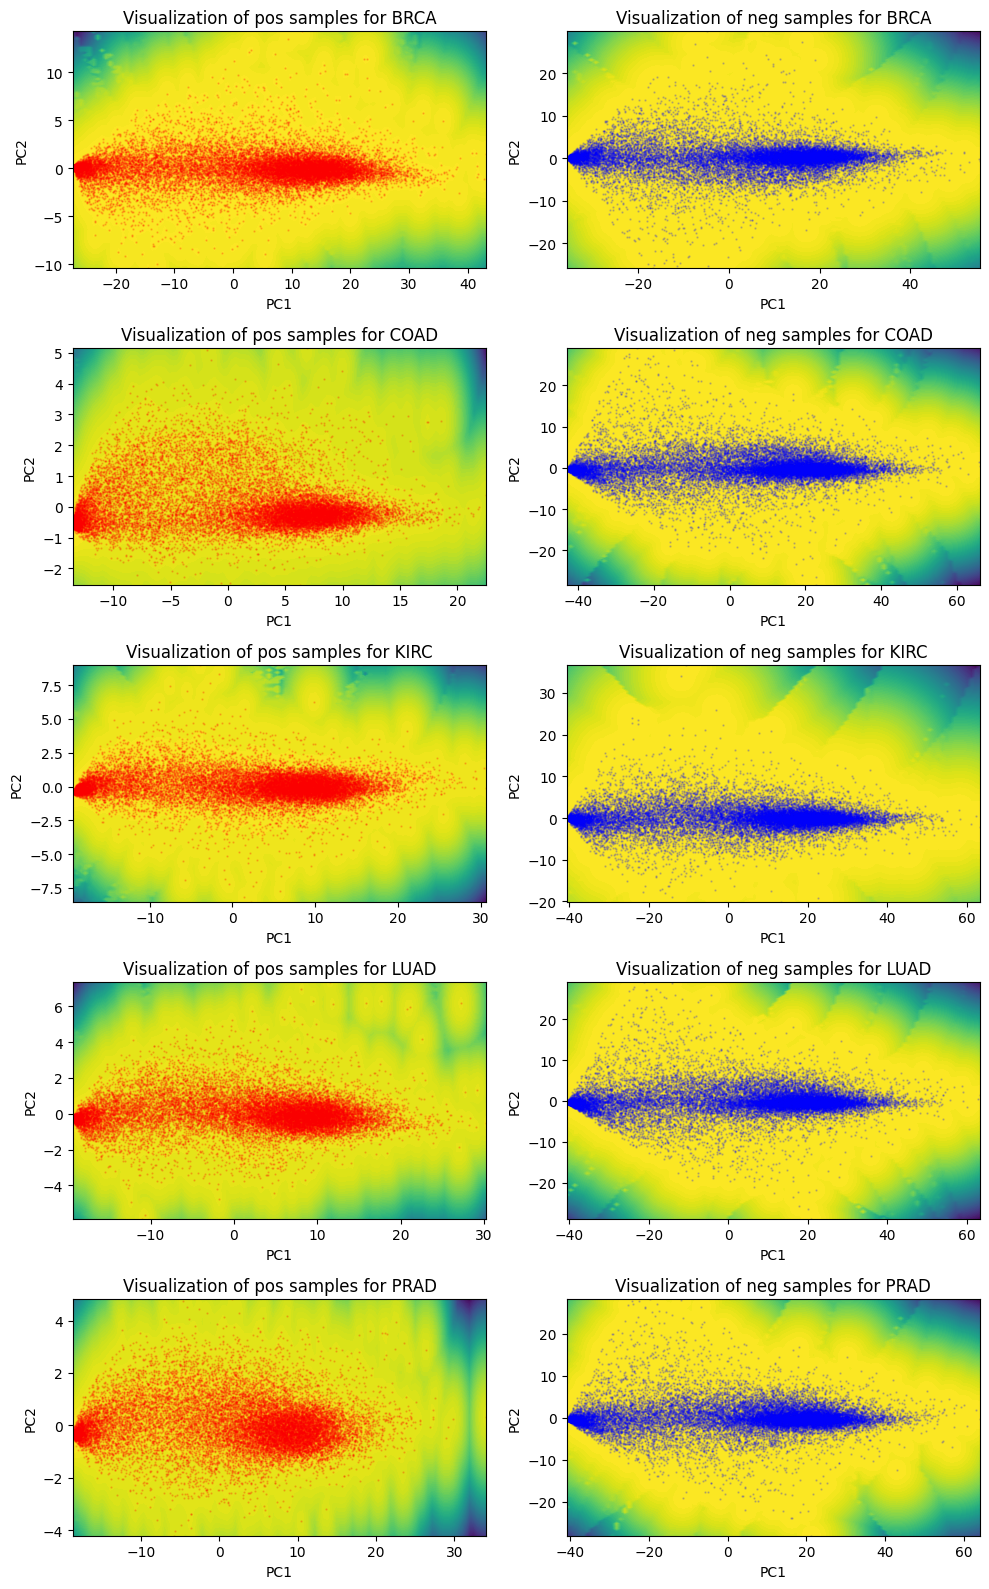

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity

tumors = ['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']
fig, axs = plt.subplots(len(tumors), 2, figsize=(10, 16))

tumor_data = pd.DataFrame(data)

for i, t in enumerate(tumors):  
    ax_pos = axs[i, 0]  
    ax_neg = axs[i, 1]  
    
    tumor_data['Class'] = labels
    tumor_data['Class'] = tumor_data['Class'].apply(lambda x: 1 if x == t else 0)

    tumor_pos = tumor_data[tumor_data['Class'] == 1].drop('Class', axis=1)
    tumor_neg = tumor_data[tumor_data['Class'] == 0].drop('Class', axis=1)

    tumor_posT = tumor_pos.T
    tumor_negT = tumor_neg.T

    tumor_posT_std = StandardScaler().fit_transform(tumor_posT)
    tumor_negT_std = StandardScaler().fit_transform(tumor_negT)

    pca_infected = PCA(n_components=2)
    pos2D = pca_infected.fit_transform(tumor_posT_std)

    pca_noninfected = PCA(n_components=2)
    neg2D = pca_noninfected.fit_transform(tumor_negT_std)

    desc = list(tumor_posT.index)

    def visualizePCA(ax, x, y, names, ttl, names_offset=0.1, c="r"):
        ax.set_title(ttl)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        kde = KernelDensity(bandwidth=0.3)  # Adjust the bandwidth as per your preference
        kde.fit(np.column_stack((x, y)))
        x_d, y_d = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
        z = kde.score_samples(np.column_stack((x_d.ravel(), y_d.ravel())))
        ax.contourf(x_d, y_d, z.reshape(x_d.shape), levels=100)
        ax.scatter(x, y, c=c, s=0.5, alpha=0.2)

    visualizePCA(ax_pos, pos2D[:, 0], pos2D[:, 1], desc, f"Visualization of pos samples for {t}", c="r",)
    visualizePCA(ax_neg, neg2D[:, 0], neg2D[:, 1], desc, f"Visualization of neg samples for {t}", c="b",)

plt.tight_layout()
plt.show()



Next we looked at using SVC and a basic gridsearch to find an optimal classifier. We ran 100 different fits and found that the best SVC had a C value of 10 and a gamma 0.0001. The test accuracy of this model was 0.963. 

In [80]:
# grid search with svc
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# standardize the data
data_scaled = StandardScaler().fit_transform(data)
encoded_labels = LabelEncoder().fit_transform(labels)
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_scaled, encoded_labels, test_size=0.2, random_state=42)


/Users/mitchellborchers/.virtualenvs/MLB/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [82]:
# grid search for the best parameters
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1]}
grid = GridSearchCV(SVC(), param_grid, verbose=3)
grid.fit(X_train, y_train)

# print the best parameters
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)
print(grid.score(X_test, y_test))

# Results (8 minutes to run)
#   {'C': 10, 'gamma': 0.0001}
#   SVC(C=10, gamma=0.0001)
#   0.9515625
#   0.9627329192546584

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...............C=0.1, gamma=0.0001;, score=0.625 total time=   4.9s
[CV 2/5] END ...............C=0.1, gamma=0.0001;, score=0.609 total time=   5.2s
[CV 3/5] END ...............C=0.1, gamma=0.0001;, score=0.633 total time=   4.6s
[CV 4/5] END ...............C=0.1, gamma=0.0001;, score=0.562 total time=   4.4s
[CV 5/5] END ...............C=0.1, gamma=0.0001;, score=0.633 total time=   4.5s
[CV 1/5] END ................C=0.1, gamma=0.001;, score=0.375 total time=   5.0s
[CV 2/5] END ................C=0.1, gamma=0.001;, score=0.375 total time=   5.1s
[CV 3/5] END ................C=0.1, gamma=0.001;, score=0.375 total time=   5.0s
[CV 4/5] END ................C=0.1, gamma=0.001;, score=0.375 total time=   5.3s
[CV 5/5] END ................C=0.1, gamma=0.001;, score=0.367 total time=   5.2s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.375 total time=   4.9s
[CV 2/5] END .................C=0.1, gamma=0.01

We also wanted to try out an unsupervised method. We used KMeans clustering to clustering and experimented with a different number of clusters.

2 11815061.447641619
3 10977312.430839065
4 10231596.265139226
5 9734654.667907968
6 9384587.103979945
7 9147223.007288206
8 9006079.945987307
9 8937004.168298602
10 8750590.86765393


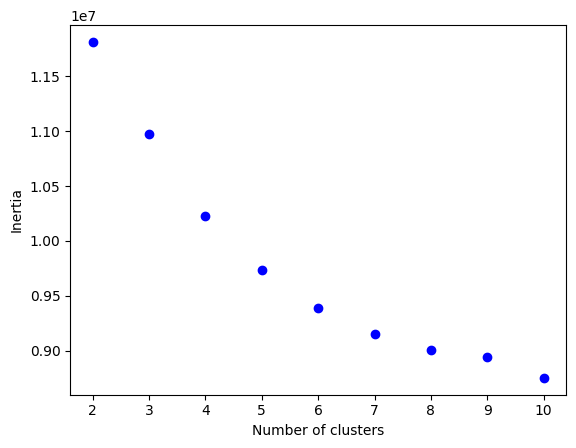

In [84]:
# kmeans clustering
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# standardize the data
data_scaled = StandardScaler().fit_transform(data)

for n in range(2, 11):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_train)
    print(n, kmeans.inertia_)
    plt.plot(n, kmeans.inertia_, 'bo')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



In [112]:
# evaluate k means clustering
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=5, n_init=300, random_state=0)
kmeans.fit(X_train, y_train)
acc = accuracy_score(y_test, kmeans.predict(X_test))
print(acc)

0.10559006211180125


### References

Cancer tumor data: TCGA-PANCAN-HiSeq-801x20531

Data Location: https://archive-beta.ics.uci.edu/dataset/401/gene+expression+cancer+rna+seq

Source: https://www.synapse.org/#!Synapse:syn4301332